In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2

In [21]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [22]:
#loading the dataset
dataset_path = path

# Defining the training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Defining the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

**Loading and prepocessing data**

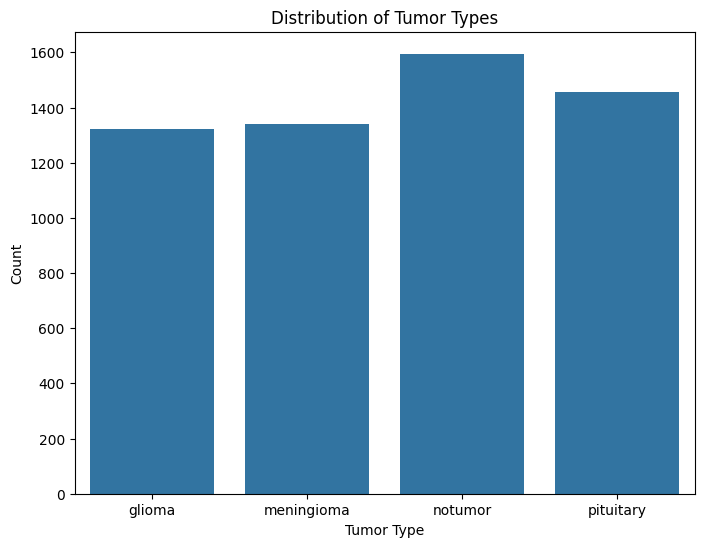

In [23]:
# Loading and preprocessing the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

# Concatenating the training data into a single DataFrame
train_df = pd.concat(train_data, ignore_index=True)

# Visualizing the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

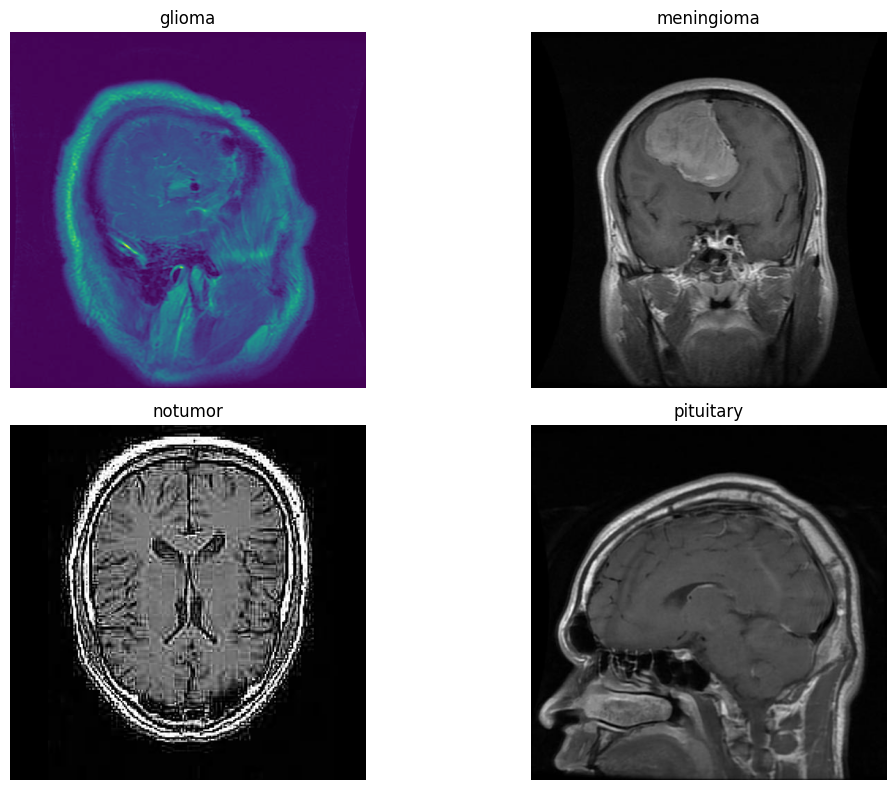

In [24]:
# Visualizing sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

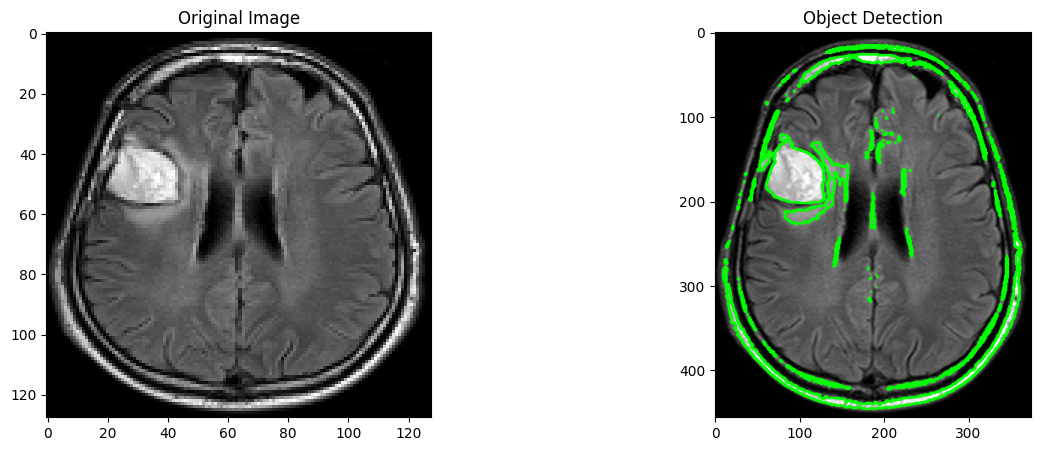

In [25]:
from skimage.measure import regionprops, label
from skimage.segmentation import clear_border
# Object Detection using Contours
# Convert the image to grayscale before thresholding
# Image preprocessing: Convert to grayscale and resize
def preprocess_image(img_path, size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    img = cv2.resize(img, size)  # Resize image
    return img  # <-- this line is missing

sample_image_path = os.path.join(train_dir, categories[1], os.listdir(os.path.join(train_dir, categories[1]))[62])
sample_img = preprocess_image(sample_image_path)

image = cv2.imread(sample_image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY) # Apply thresholding to the grayscale image

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

object_detected = image.copy()  # Create a copy to avoid modifying the original image
cv2.drawContours(object_detected, contours, -1, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(sample_img, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(object_detected)
ax[1].set_title("Object Detection")
plt.show()

**SETTING UP THE IMAGE_SIZE, BATCH_SIZE AND EPOCHS FOR THE MODEL:**

In [26]:

image_size = (150, 150)

# Seting the number of epochs for training
batch_size = 32

# Set the number of epochs for training
epochs = 10

**DATA AUGMENTATION AND PREPROCESSING:**

In [27]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


** BUILDING THE MODEL ARTITECHURE**

In [28]:
# model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
#model training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.4974 - loss: 1.0961 - val_accuracy: 0.5578 - val_loss: 1.1591
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.6250 - loss: 0.9604

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.6250 - loss: 0.9604 - val_accuracy: 0.5039 - val_loss: 1.2979
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.6993 - loss: 0.7649 - val_accuracy: 0.6062 - val_loss: 1.0130
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.8125 - loss: 0.4513 - val_accuracy: 0.6414 - val_loss: 0.9246
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7497 - loss: 0.6303 - val_accuracy: 0.6469 - val_loss: 0.8958
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.8438 - loss: 0.5082 - val_accuracy: 0.6133 - val_loss: 0.9978
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.7703 - loss: 0.5898 - val_accuracy: 0.7203 - val_loss: 0.7436
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.9062 - loss: 0.2505 - val_accuracy: 0.7461 - val_loss: 0.6655
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.8030 - loss: 0.5004 - val_accurac

**Visualization**

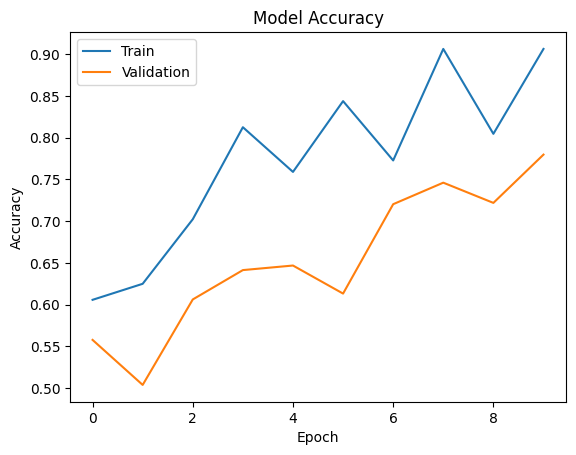

In [30]:
# Ploting the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

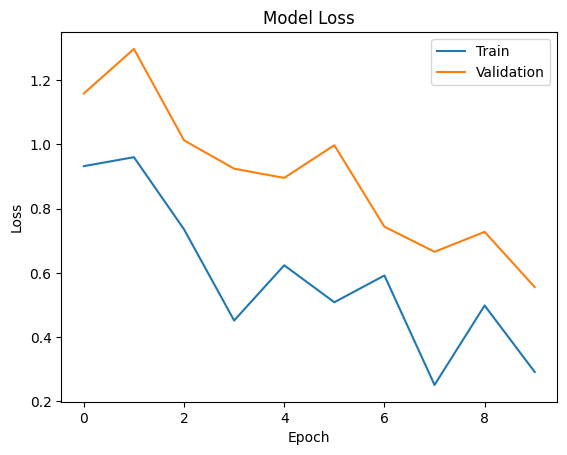

In [31]:
# Ploting the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

**Evaluation**

In [32]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 553ms/step - accuracy: 0.6965 - loss: 0.7087
Test Loss: 0.5554461479187012
Test Accuracy: 0.7796875238418579


**Confusion matrix**

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 648ms/step


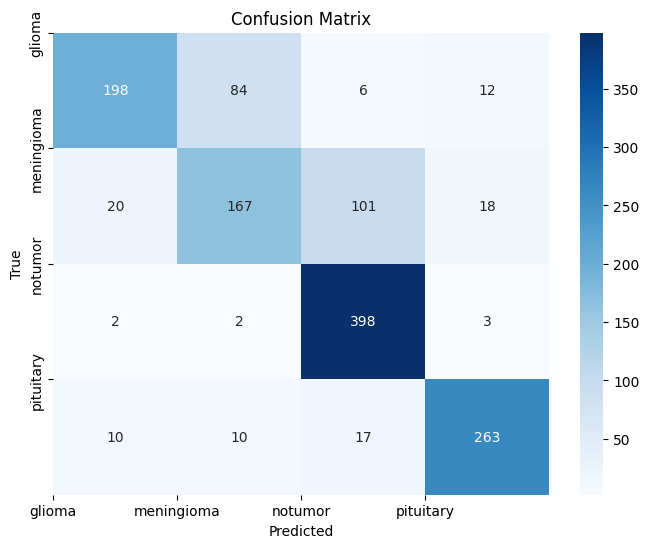

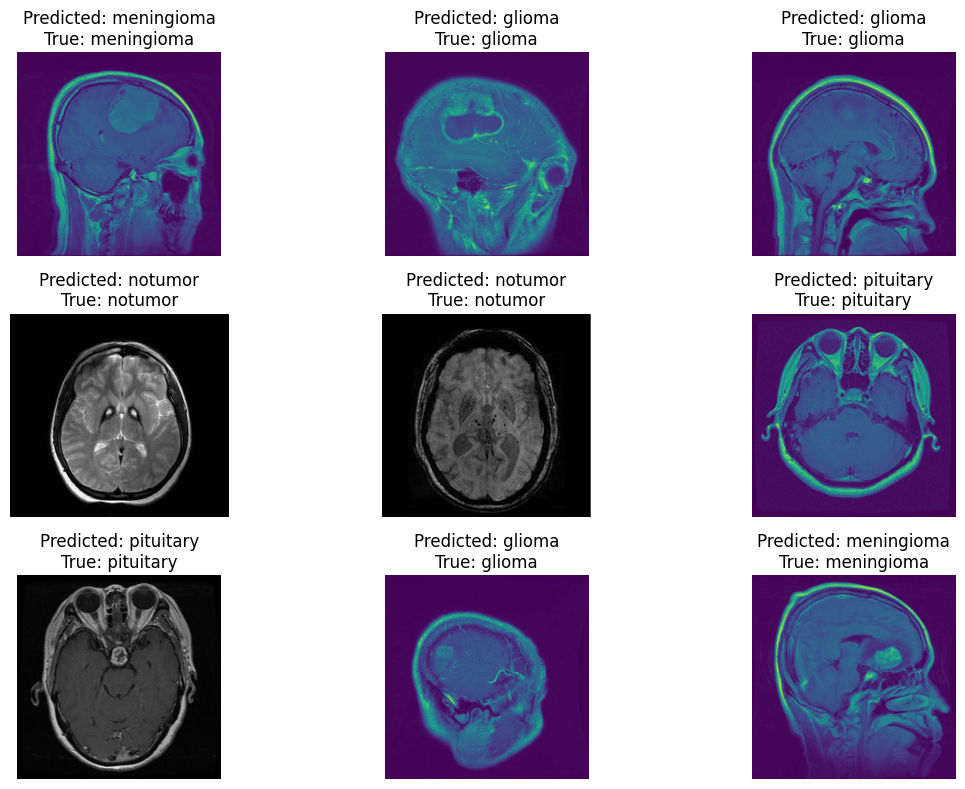

In [33]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.8608695652173913
Recall: 0.66
F1-Score: 0.7471698113207548

Class: meningioma
Precision: 0.6349809885931559
Recall: 0.545751633986928
F1-Score: 0.5869947275922671

Class: notumor
Precision: 0.7624521072796935
Recall: 0.9827160493827161
F1-Score: 0.8586839266450916

Class: pituitary
Precision: 0.8885135135135135
Recall: 0.8766666666666667
F1-Score: 0.8825503355704699



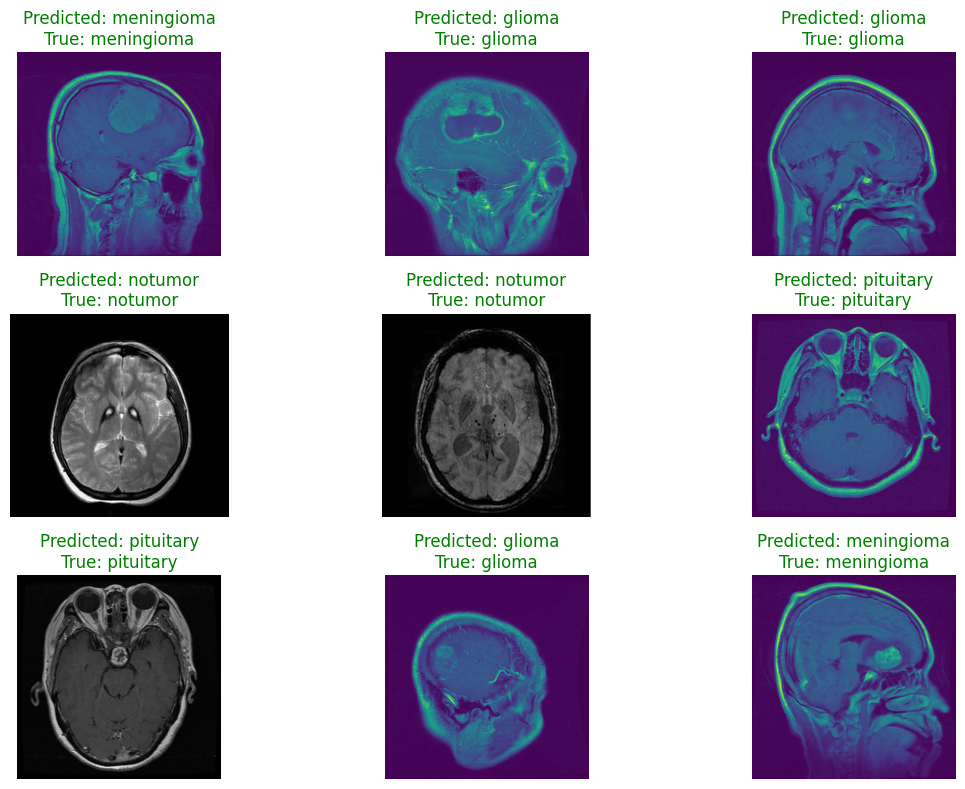

In [34]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()